In [5]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import log
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection
from matplotlib.ticker import MaxNLocator
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\VF6603\OneDrive - ENGIE\Escritorio\Codes\TFG


In [6]:
# cargamos reultados de los dos barridos
barr_LCEs_random = np.load("data/barrido_LCEs_random.npy")
barr_exts_random = np.load("data/barrido_exts_random.npy")
print(barr_LCEs_random.shape)
print(barr_exts_random.shape)

(5000, 3)
(5000, 3)


# Análisis de LCEs vs $\sigma$º

## Para un $x_0$ distinto en cada iteración
Ahora pruebo con el $x_0$ random en cada iteración

In [4]:
### NO EJECUTAR, TARDA MUCHO (~3h)
## se pueden cargar los resultados de un CSV ya hecho

from src.functions import barrido_LCEs_random
barr_random = barrido_LCEs_random(
    total_time=5000,
    N_points=1e5,
    max_iters=5000
)

c:\Users\VF6603\OneDrive - ENGIE\Escritorio\Codes\TFG\src\stoc_system.py:179: RuntimeWarning: Mean of empty slice
  lambda1 = np.nanmean(lambda_estimates) if lambda_estimates else 0.0
c:\Users\VF6603\OneDrive - ENGIE\Escritorio\Codes\TFG\src\functions.py:207: RuntimeWarning: Mean of empty slice
  mean_val = np.nanmean(vect_lambdas)
c:\Users\VF6603\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


KeyboardInterrupt: 

In [ ]:
# guardamos los resultados porque son pesados
np.save('data/barrido_LCEs_random.npy', barr_random)

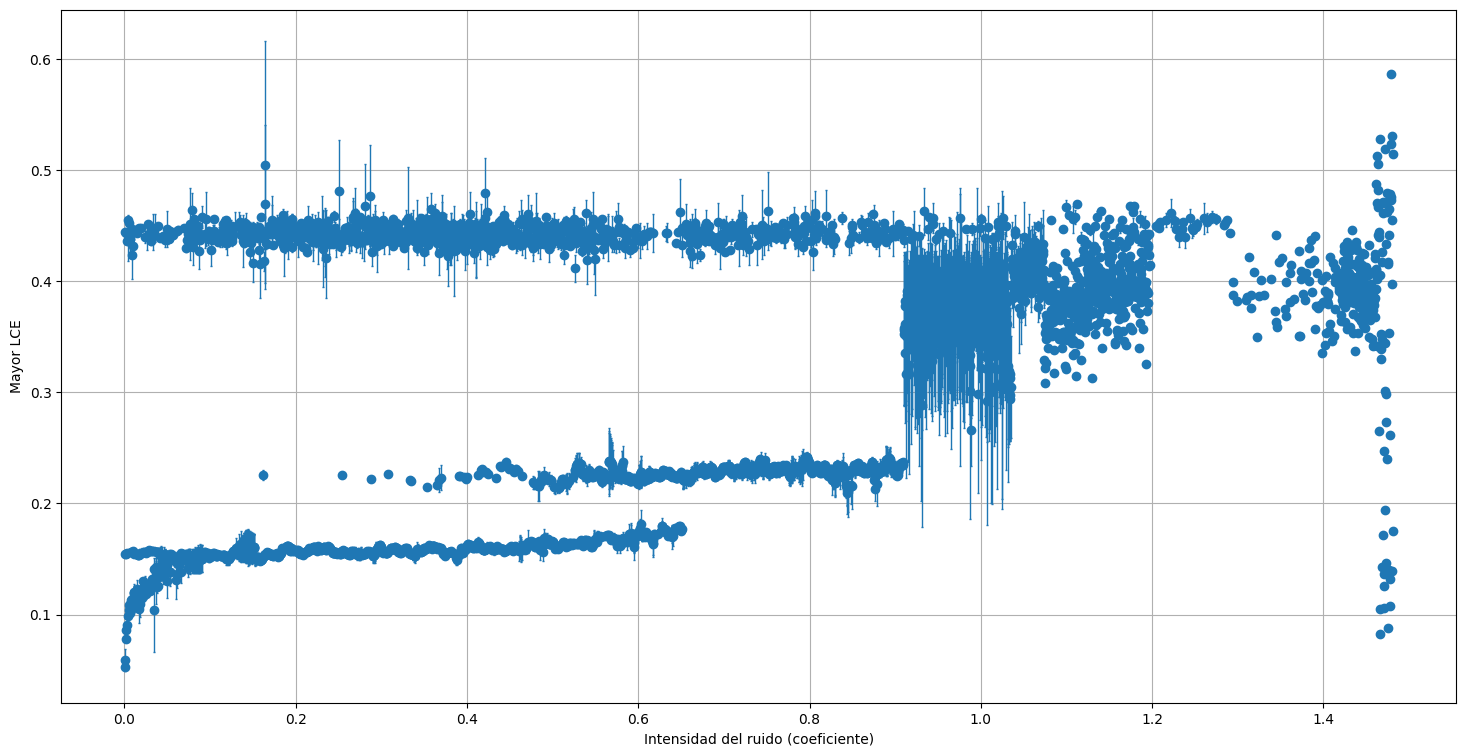

In [ ]:
# creamos una gráfica para verlo
fig_barridos, ax_barridos = plt.subplots(figsize = (18,9))
plt.errorbar(
    x = barr_random[:, 0], y = barr_random[:, 1], yerr = barr_random[:, 2], fmt = 'o', elinewidth = 1, capsize = 1 
)

plt.xlabel('Intensidad del ruido (coeficiente)')
plt.ylabel('Mayor LCE')                                                                           
plt.grid()
plt.show()

## Diagrama de bifurcaciones

<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:44: SyntaxWarning: invalid escape sequence '\l'
C:\Users\kikek\AppData\Local\Temp\ipykernel_114464\1463847563.py:43: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('$\sigma$', fontsize=16, weight='semibold')
C:\Users\kikek\AppData\Local\Temp\ipykernel_114464\1463847563.py:44: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\lambda_1$', fontsize=16, weight='semibold')


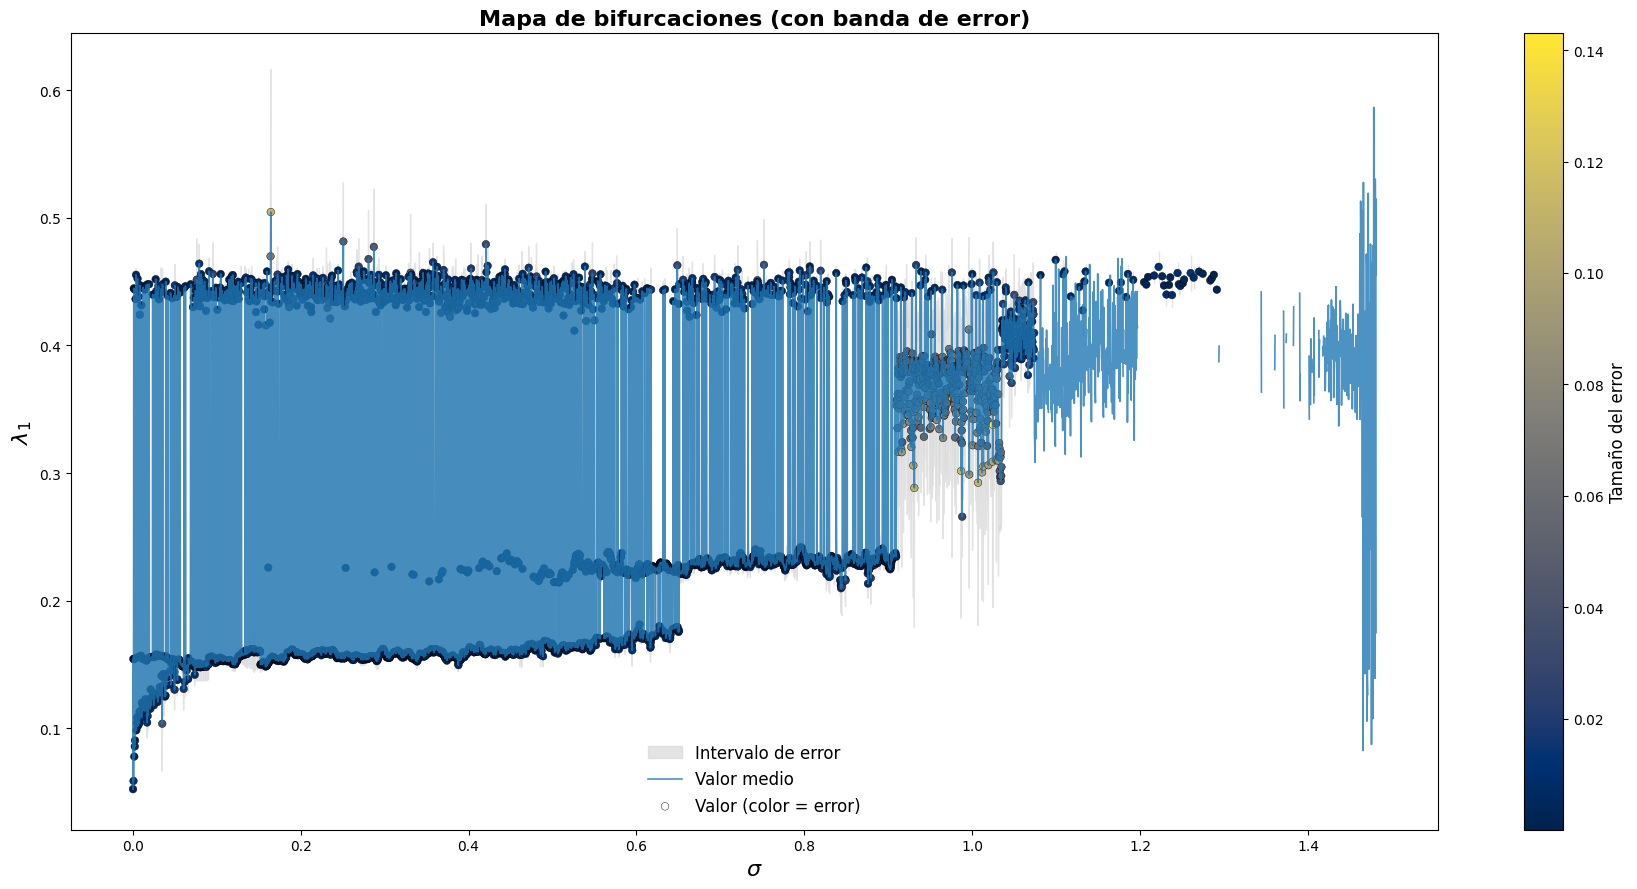

In [ ]:

r   = barr_random[:, 0]
x   = barr_random[:, 1]
err = barr_random[:, 2]

fig, ax = plt.subplots(figsize=(18,9))

# 1) Banda sombreada de incertidumbre
ax.fill_between(
    r,
    x - err,
    x + err,
    color='lightgray',
    alpha=0.6,
    label='Intervalo de error'
)

# 2) Línea conectando los valores centrales
ax.plot(
    r,
    x,
    '-',
    linewidth=1.2,
    alpha=0.8,
    label='Valor medio'
)

# 3) Scatter coloreado según magnitud del error
sc = ax.scatter(
    r,
    x,
    c=err,
    cmap='cividis',
    s=30,
    edgecolor='k',
    linewidth=0.3,
    label='Valor (color = error)'
)
cbar = fig.colorbar(sc, ax=ax)
cbar.ax.set_ylabel('Tamaño del error', fontsize=12)

# 4) Estética
ax.set_title('Mapa de bifurcaciones (con banda de error)', fontsize=16, weight='bold')
ax.set_xlabel('$\sigma$', fontsize=16, weight='semibold')
ax.set_ylabel('$\lambda_1$', fontsize=16, weight='semibold')
ax.grid(False)
ax.legend(frameon=False, fontsize=12)

fig.tight_layout()
plt.show()

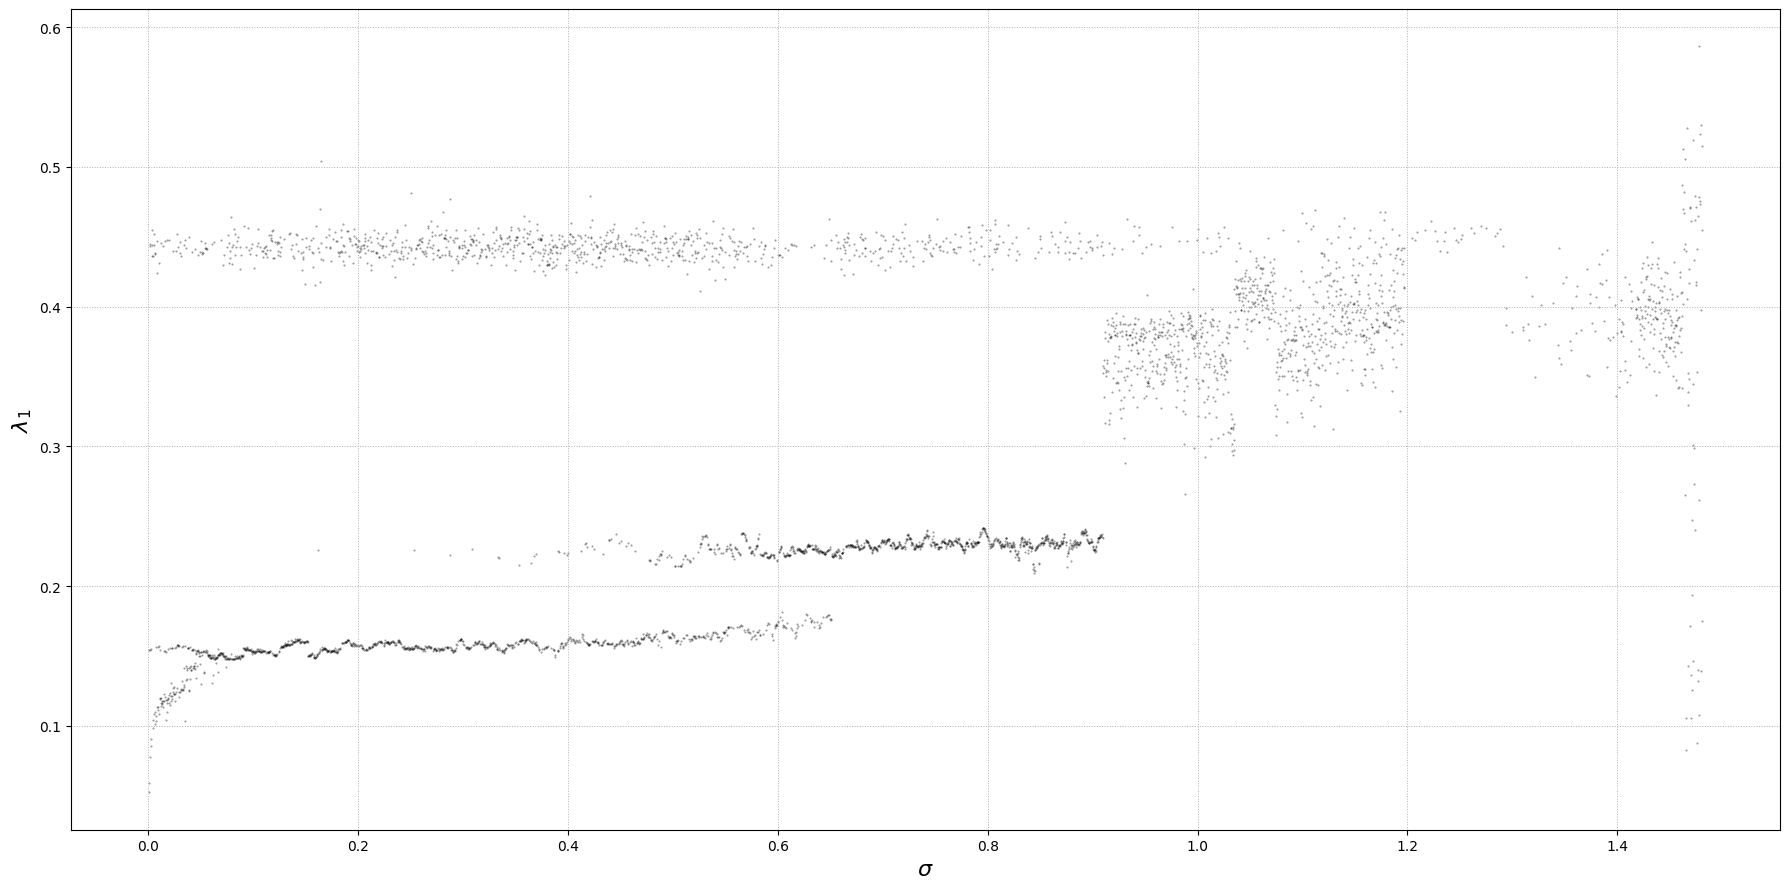

In [ ]:
# extraemos parámetros
sigma = barr_random[:, 0]
lces = barr_random[:, 1]
delta = barr_random[:, 2]

fig, ax = plt.subplots(figsize=(18, 9))

# scatter estilo bifurcación: muchos puntos chiquititos y algo transparentes
ax.scatter(
    sigma, lces,
    s=1,                    # tamaño de punto muy pequeño
    alpha=0.4,                # transparencia para ver densidades
    marker='.',               # marcador puntiagudo
    color='black'             # clásico negro
)



ax.set_xlabel(r'$\sigma$', fontsize=16)
ax.set_ylabel(r'$\lambda_1$', fontsize=16)

ax.grid(True, linestyle=':', linewidth=.7)

fig.tight_layout()
plt.show()

Puedo introducir más puntos dentro del rango del error para verlo mejor

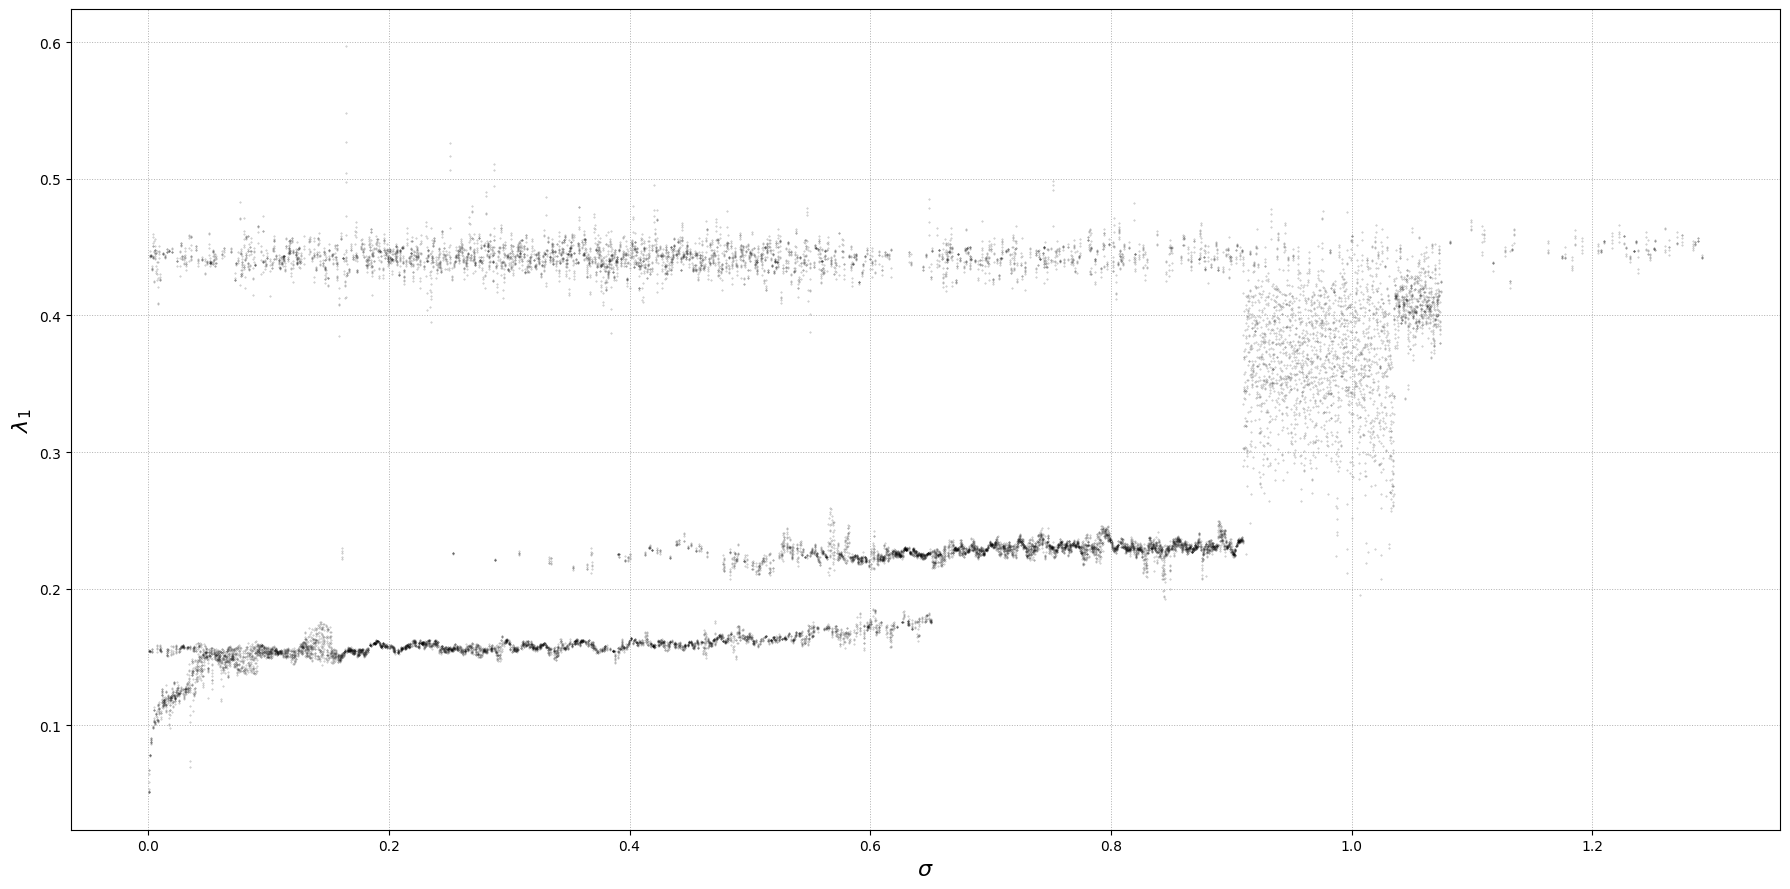

In [ ]:
# simulamos dispersión dentro del error para dar densidad
n_rep = 5  # cuántos puntos extra por valor de sigma
sigma_rep = np.repeat(sigma, n_rep)

# distribuimos uniformemente en [lces-delta, lces+delta]
lces_jitter = np.repeat(lces, n_rep) + (np.random.rand(len(sigma_rep)) * 2 - 1) * np.repeat(delta, n_rep)

fig, ax = plt.subplots(figsize=(18, 9))

# scatter estilo bifurcación: muchos puntos chiquititos y algo transparentes
ax.scatter(
    sigma_rep, lces_jitter,
    s=0.5,                    # tamaño de punto muy pequeño
    alpha=0.3,                # transparencia para ver densidades
    marker='.',               # marcador puntiagudo
    color='black'             # clásico negro
)


ax.set_xlabel(r'$\sigma$', fontsize=16)
ax.set_ylabel(r'$\lambda_1$', fontsize=16)

ax.grid(True, linestyle=':', linewidth=.7)

fig.tight_layout()
plt.show()

# Análisis de Extinciones vs $\sigma$
Podemos hacer lo mismo ahora para las extinciones

In [ ]:

# ! WARNING: tarda mucho 

from src.functions import barrido_extinciones_random
barr_exts_random = barrido_extinciones_random(
    total_time=5000,
    N_points=1e5,
    max_iters=5000
)

In [23]:
np.save('data/barrido_exts_random.npy', barr_exts_random)

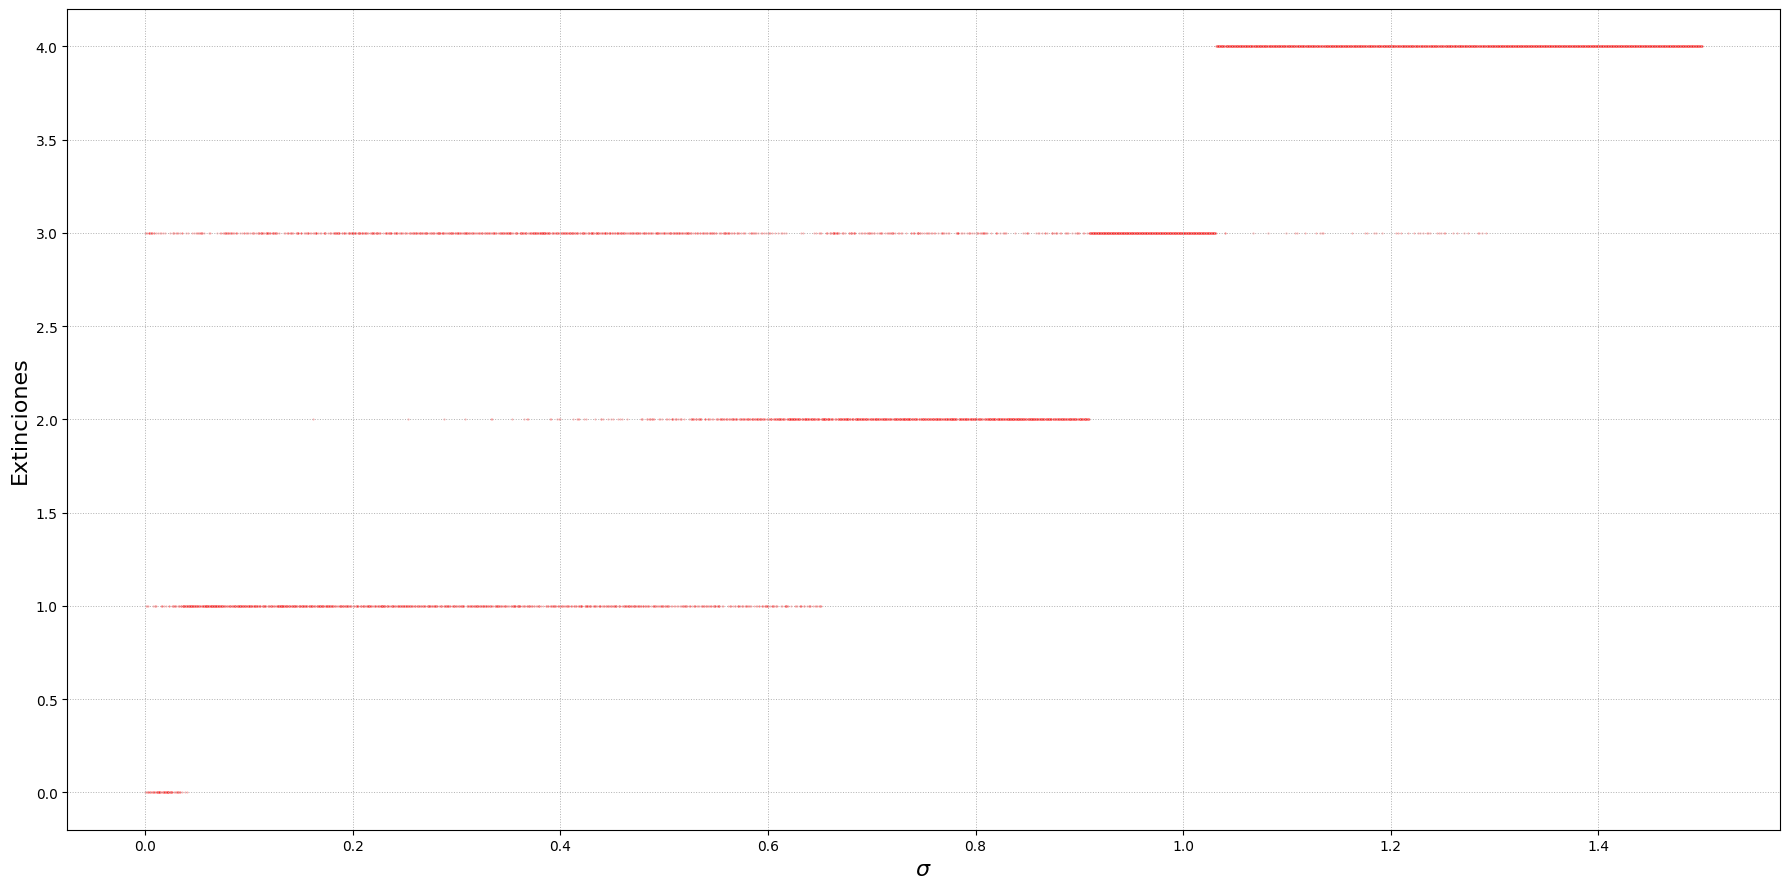

In [25]:
fig, ax = plt.subplots(figsize=(18, 9))

# scatter estilo bifurcación: muchos puntos chiquititos y algo transparentes
ax.scatter(
    barr_exts_random[:,0], barr_exts_random[:,1],
    s=1,                    # tamaño de punto muy pequeño
    alpha=0.3,                # transparencia para ver densidades
    marker='.',               
    color='red'             
)



ax.set_xlabel(r'$\sigma$', fontsize=16)
ax.set_ylabel('Extinciones', fontsize=16)

ax.grid(True, linestyle=':', linewidth=.7)

fig.tight_layout()
plt.show()

## Figura conjunta

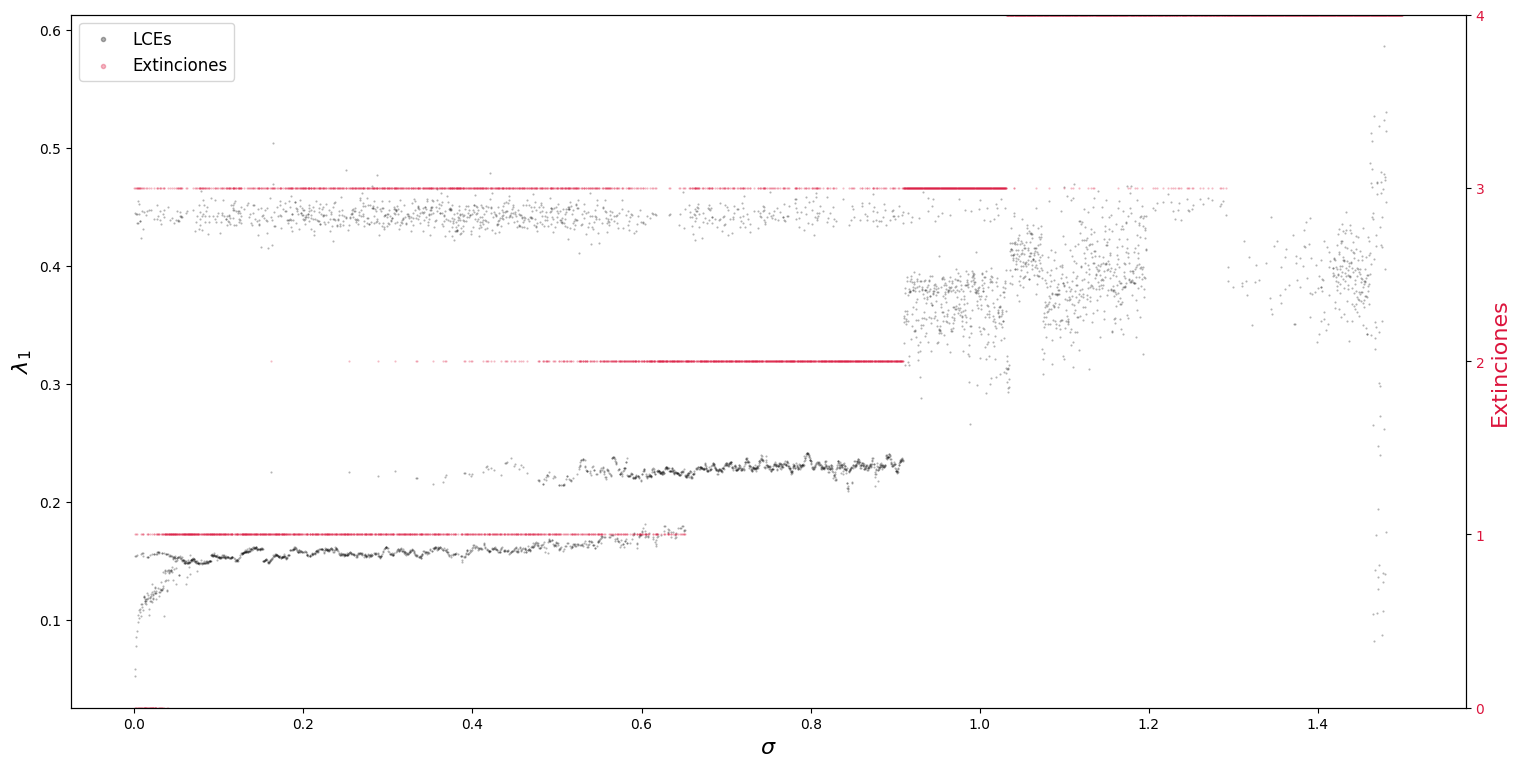

In [37]:

# Creamos la figura y el primer eje
fig, ax1 = plt.subplots(figsize=(18, 9))

# Scatter en ax1
ax1.scatter(
    barr_LCEs_random[:,0], barr_LCEs_random[:,1],
    s=1, alpha=0.3, marker='.', color='black',
    label='LCEs'
)
ax1.set_xlabel(r'$\sigma$', fontsize=16)
ax1.set_ylabel(r'$\lambda_1$', fontsize=16, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Grid en el eje principal
# ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Creamos el segundo eje Y (derecho)
ax2 = ax1.twinx()
ax2.scatter(
    barr_exts_random[:,0], barr_exts_random[:,1],
    s=1, alpha=0.3, marker='.', color='crimson',
    label='Extinciones'
)
ax2.set_ylabel('Extinciones', fontsize=16, color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

# Límite de 0 a 4 y ticks enteros en el eje Y derecho
ax2.set_ylim(0, 4)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Leyenda combinada con marcadores más grandes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc='upper left',
    scatterpoints=1,    # un punto por entrada
    markerscale=6,      # escala de marcadores en la leyenda
    frameon=True,
    fontsize=12
)

plt.show()

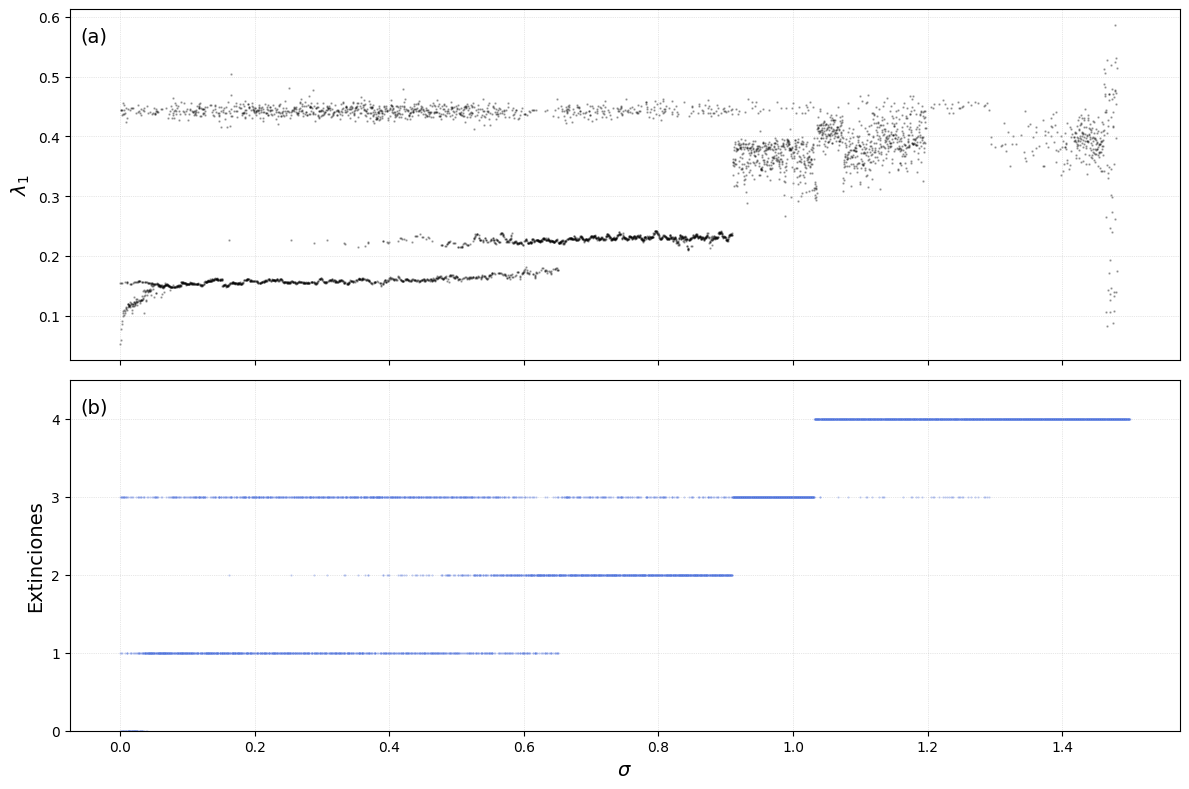

In [38]:
fig_barrido, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

# λ1 en escala de grises
ax1.scatter(barr_LCEs_random[:,0], barr_LCEs_random[:,1],
            s=.5, alpha=0.3, color='black')
ax1.set_ylabel(r'$\lambda_1$', fontsize=14)
ax1.grid(True, which='major', linestyle=':', linewidth=0.5, alpha=0.6)
ax1.text(0.01, 0.95, '(a)', transform=ax1.transAxes, fontsize=14, va='top')

# Extinciones
ax2.scatter(barr_exts_random[:,0], barr_exts_random[:,1],
            s=.3, alpha=0.3, color='royalblue')
ax2.set_ylabel('Extinciones', fontsize=14)
ax2.set_xlabel(r'$\sigma$', fontsize=14)
ax2.set_ylim(0, 4.5)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.grid(True, which='major', linestyle=':', linewidth=0.5, alpha=0.6)
ax2.text(0.01, 0.95, '(b)', transform=ax2.transAxes, fontsize=14, va='top')

plt.tight_layout()
plt.show()


In [ ]:
# fig_barrido.savefig('outputs/barrido_LCEs_exts_random.png', dpi=600)

# Estudio de los tiempos de extinción
Aquí como no tenemos que hallar los LCEs, podemos hacer varias iteraciones de la trayectoria random y hallar su valor promedio.

In [ ]:
def barrido_t_ext_random(total_time = 5000, N_points = 1e5, max_iters = 50):
    """
    Función para hacer un barrido de la intensidad de ruido y el tiempo medio de extinción para cada uno.
    :param total_time: Tiempo total de la simulación.
    :param N_points: Número de puntos a simular.
    :param max_iters: Número máximo de iteraciones para la simulación.
    :return: Un array de numpy con los resultados del barrido.
    """

    # barrido de la intensidad del ruido
    for idx, sigma in enumerate(array_sigmas):

        
        
        # generamos el x0 aletaorio

        # creamos el sistemas estocástico y lo resolvemos


        #
